In [51]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from pathlib import Path

In [32]:
what_were_covering = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

<h3>Data Preparation</h3>

In [33]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [34]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [35]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')
    plt.scatter(test_data, test_labels, c='g', s=4, label='Testing data')
    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')
    plt.legend(prop={'size': 14})

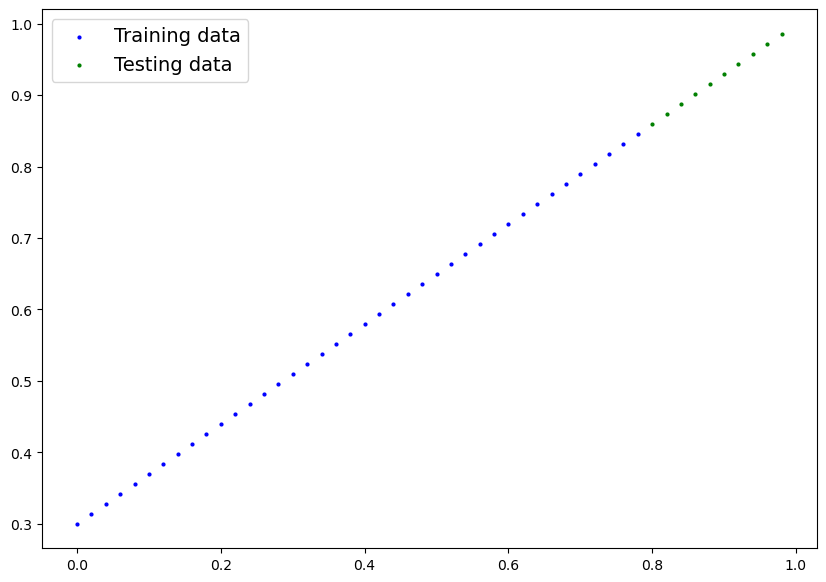

In [36]:
plot_predictions()

<h3>Build Model</h3>

In [37]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, # start with random weights
                                                dtype=torch.float),
                                    requires_grad=True) # update with gradient descent

        self.bias = nn.Parameter(torch.randn(1, # start with random bias
                                            dtype=torch.float),
                                requires_grad=True) # update with gradient descent
    def forward(self, x: torch.Tensor) -> torch.Tensor: # x is the input data, like train/test features
        return self.weights * x + self.bias # linear regression y=m*x + b                                

torch.nn - contains building blocks for computational graphs\
torch.nn.Parameter - stores tensors that can be used with nn.Module\
torch.nn.Module - base class for neural network modules, all building blocks for neural networks are subclasses, requires forward()\
torch.optim - contains optimization algorithms for improving model parameters in nn.Parameter

In [38]:
torch.manual_seed(42)
model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [39]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [40]:
# turns off stuff like gradient tracking which is unnecessary for just forward passing in inference to make it faster
with torch.inference_mode():
    y_preds = model_0(X_test)

In [41]:
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


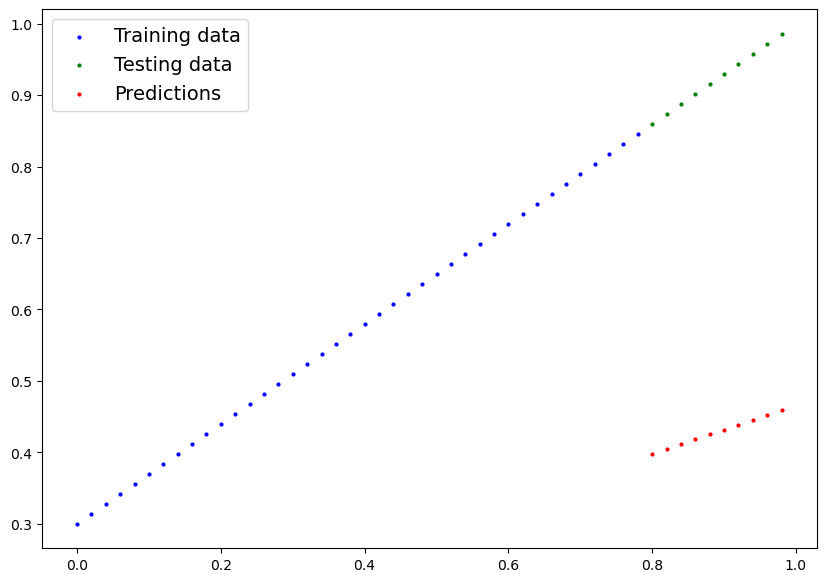

In [42]:
plot_predictions(predictions=y_preds)

In [43]:
# not so yay for random parameter values
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

<h3>Train Model</h3>

loss function - in torch.nn, includes MAE and cross entropy\
optimizer - in torch.optim, includes SGD

In [44]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_0.parameters(), # optimizing the weights and bias
                            lr=0.01) # hyperparameter learning rate

**Training loop**\
Forward pass - forward() calculated on training data\
Calculate loss - model's predictions are compared to ground truth\
Zero gradients - optimizer gradients set to zero to be recalculated for each training step\
Backpropagation - compute gradient of loss w.r.t model parameters (parameters with requires_grad=True)\
Gradient descent/update optimizer - update parameters w.r.t loss gradients\

**Test loop**\
Forward pass, calculate loss, evaluation

In [45]:
epochs = 200

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    # put model in training mode
    model_0.train()

    # forward pass using forward()
    y_pred = model_0(X_train)

    # calculate loss
    loss = loss_fn(y_pred, y_train)

    # zero grad of optimizer
    optimizer.zero_grad()

    # backpropagation
    loss.backward()

    # update optimizer
    optimizer.step()

    # put mode in evaluation mode
    model_0.eval()

    with torch.inference_mode():
        test_pred = model_0(X_test)
        test_loss = loss_fn(test_pred, y_test.type(torch.float))
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819 
Epoch: 100 | MAE Train Loss: 0.024458957836031914 | MAE Test Loss: 0.05646304413676262 
Epoch: 110 | MAE Train Loss: 0.021020207554101944 | MAE

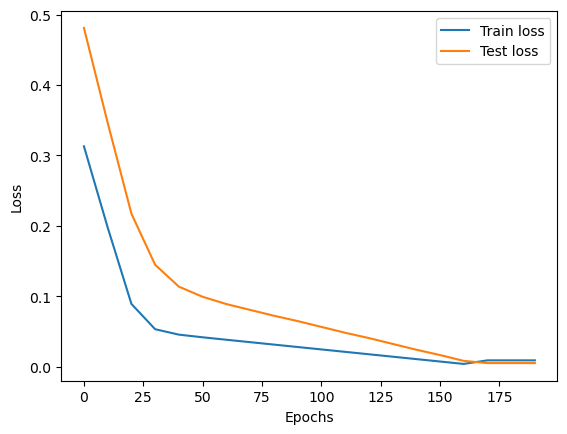

In [46]:
plt.plot(epoch_count, train_loss_values, label='Train loss')
plt.plot(epoch_count, test_loss_values, label='Test loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

In [47]:
print('The model learned the following values for weights and bias:')
print(model_0.state_dict())
print('Original values for weights and bias:')
print(f'weights: {weight}, bias: {bias}')

The model learned the following values for weights and bias:
OrderedDict({'weights': tensor([0.6990]), 'bias': tensor([0.3093])})
Original values for weights and bias:
weights: 0.7, bias: 0.3


<h3>Predictions</h3>

In [49]:
model_0.eval()

with torch.inference_mode():
    y_preds = model_0(X_test)
y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

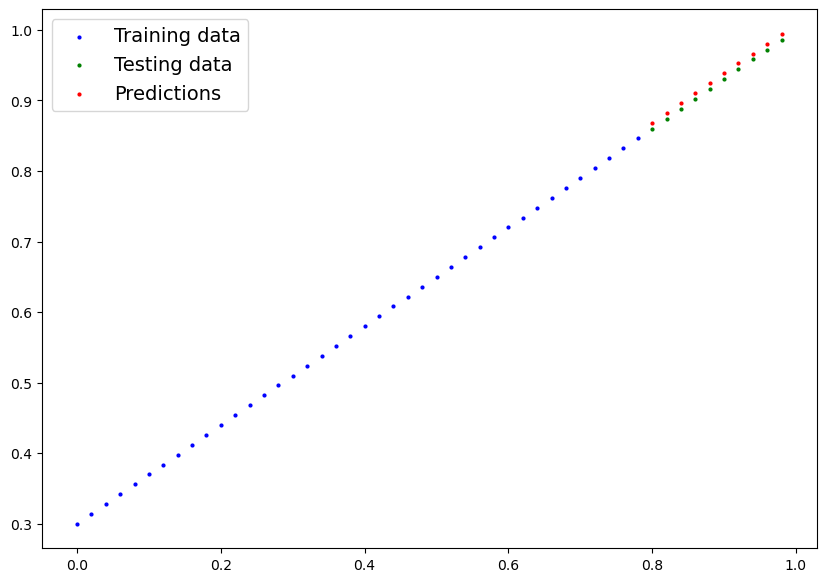

In [50]:
plot_predictions(predictions=y_preds)

<h3>Saving Model</h3>

torch.save - saves serialized object to disk using 'pickle'. Can save models, tensors, and other Python objects\
torch.load - uses 'pickle' to unpickle/deserialize and load Python object files into memoy\
torch.nn.Module.load_state_dict - loads a model's parameter dictionary using a saved state_dict() object\
(picke is not secure so don't unpickle a virus)

In [52]:
# create model's directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# create model save path
MODEL_NAME = '01_pytorch_workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# save the model state dict
print(f'Saving mode to: {MODEL_SAVE_PATH}')
torch.save(obj=model_0.state_dict(), # saves model's learned parameters
           f=MODEL_SAVE_PATH)

Saving mode to: models\01_pytorch_workflow_model_0.pth


'ls' is not recognized as an internal or external command,
operable program or batch file.
